## Imports

In [1]:
import numpy as np
import pickle
import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from scipy.sparse import hstack, vstack
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

## Plot Helper Function

In [2]:
def plotROC(model, X_test, y_test, labelA, labelB):
    ns_probs = [0 for _ in range(len(y_test))]
    
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    
    # axis labels
    pyplot.title('ROC Curve - ' + labelA + ', ' + labelB)
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    
    # show the legend
    pyplot.legend()
    
    # show the plot
    pyplot.show()

## Load and Process Data

### FAA Labelled Data

In [3]:
# Load Matched Data (Positive)
matches = pd.read_csv('data/HumanAnnotatedMatches_SVO_DB_20200127_pipes_noquotes.csv', encoding='UTF-8', on_bad_lines='skip', engine="python", delimiter='|' )
good_ids_og = matches['NOTAM_REC_ID']

# Load Matched Data (Negative)
non_matches = pd.read_csv('data/HumanAnnotatedMatches_poormatches_SVO_DB_20201027.csv', encoding='windows-1252')
bad_ids_og = non_matches['NOTAM_REC_ID']

# Load All Data
all_notams = pd.read_pickle("data/allData.pkl")

### Handmade Labelled Data

In [4]:
good_ids = np.ravel(pd.read_csv('data/handmade_good_matches.csv', header=None))
bad_ids = np.ravel(pd.read_csv('data/handmade_bad_matches.csv', header=None))

### Subsample Poor Matches

In [5]:
sub_bad_ids = np.random.choice(bad_ids, 8 * len(good_ids))

### Encode Categorical Variables

In [6]:
# Initialize Label Encoders
le = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()
le3 = preprocessing.LabelEncoder()

# Type Encoder
all_notams['NOTAM_TYPE_ENCODE'] = le.fit_transform(all_notams['NOTAM_TYPE'])

# Classification Encoder
all_notams['CLASSIFICATION_ENCODE'] = le2.fit_transform(all_notams['CLASSIFICATION'])

# Location Code
all_notams['LOCATION_CODE_ENCODE'] = le3.fit_transform(all_notams['LOCATION_CODE'])

In [7]:
# Set Features
features = ['NOTAM_TYPE_ENCODE', 'TEXT', 'CLASSIFICATION_ENCODE', 'MIN_ALT', 'MAX_ALT', 'LOCATION_CODE_ENCODE']

In [8]:
# Get Positive NOTAM Data
good_notams = all_notams[all_notams['NOTAM_REC_ID'].isin(good_ids)][features]

# Get Negaitve NOTAM Data
bad_notams = all_notams[all_notams['NOTAM_REC_ID'].isin(sub_bad_ids)][features]

# Get Positive NOTAM Data
good_notams_og = all_notams[all_notams['NOTAM_REC_ID'].isin(good_ids_og)][features]

# Get Negaitve NOTAM Data
bad_notams_og = all_notams[all_notams['NOTAM_REC_ID'].isin(bad_ids_og)][features]

### Encode NOTAM Message

In [9]:
# Message Embedding
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english', max_features=10000)

# Fit and Transform All Data
all_encodes = tfidf.fit_transform(all_notams['TEXT'])

# Transform Positive Data
good_encodes = tfidf.transform(good_notams['TEXT'])

# Transform Negative Data
bad_encodes = tfidf.transform(bad_notams['TEXT'])

# Transform Positive Data
good_encodes_og = tfidf.transform(good_notams_og['TEXT'])

# Transform Negative Data
bad_encodes_og = tfidf.transform(bad_notams_og['TEXT'])

In [10]:
# Check Cols
bad_notams.columns

Index(['NOTAM_TYPE_ENCODE', 'TEXT', 'CLASSIFICATION_ENCODE', 'MIN_ALT',
       'MAX_ALT', 'LOCATION_CODE_ENCODE'],
      dtype='object')

In [11]:
# Check Data
bad_notams.head()

,NOTAM_TYPE_ENCODE,TEXT,CLASSIFICATION_ENCODE,MIN_ALT,MAX_ALT,LOCATION_CODE_ENCODE
31,1,runway island wet,4,0.0,999.0,4163
43,2,navigation instrument landing system runway gl...,0,0.0,999.0,6306
149,1,navigation vor and tacan (collocated) out of s...,0,0.0,999.0,4897
179,1,iap yampa valley hayden county instrument land...,1,0.0,999.0,7062
369,1,rate of climb distance measuring equipment int...,2,0.0,999.0,11691


### Create Labels

In [12]:
# Set Classification Labels
good_notams['LABEL'] = 1
bad_notams['LABEL'] = 0

# Set Classification Labels
good_notams_og['LABEL'] = 1
bad_notams_og['LABEL'] = 0

### Prepare Data for Models

In [13]:
# Combine Features (Positive)
positive = hstack((good_notams['NOTAM_TYPE_ENCODE'].array[:,None], 
                   good_encodes,
                   good_notams['CLASSIFICATION_ENCODE'].array[:,None],
                   good_notams['MIN_ALT'].array[:,None],
                   good_notams['MAX_ALT'].array[:,None],
                   good_notams['LOCATION_CODE_ENCODE'].array[:,None])).A

# Combine Features (Negative)
negative = hstack((bad_notams['NOTAM_TYPE_ENCODE'].array[:,None], 
                   bad_encodes,
                   bad_notams['CLASSIFICATION_ENCODE'].array[:,None],
                   bad_notams['MIN_ALT'].array[:,None],
                   bad_notams['MAX_ALT'].array[:,None],
                   bad_notams['LOCATION_CODE_ENCODE'].array[:,None])).A

# Combine Features (Positive)
positive_og = hstack((good_notams_og['NOTAM_TYPE_ENCODE'].array[:,None], 
                   good_encodes_og,
                   good_notams_og['CLASSIFICATION_ENCODE'].array[:,None],
                   good_notams_og['MIN_ALT'].array[:,None],
                   good_notams_og['MAX_ALT'].array[:,None],
                   good_notams_og['LOCATION_CODE_ENCODE'].array[:,None])).A

# Combine Features (Negative)
negative_og = hstack((bad_notams_og['NOTAM_TYPE_ENCODE'].array[:,None], 
                   bad_encodes_og,
                   bad_notams_og['CLASSIFICATION_ENCODE'].array[:,None],
                   bad_notams_og['MIN_ALT'].array[:,None],
                   bad_notams_og['MAX_ALT'].array[:,None],
                   bad_notams_og['LOCATION_CODE_ENCODE'].array[:,None])).A

### Init Stratified Shuffle Splits

In [14]:
# Intitialize K-Fold Split for Cross Validation
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.30, train_size=0.70, random_state=232323)

# Combine Postive and Negative Data
X = vstack((positive, negative))
y = vstack((good_notams['LABEL'].array[:,None], bad_notams['LABEL'].array[:,None]))

# Intitialize K-Fold Split for Cross Validation
sss_og = StratifiedShuffleSplit(n_splits=5, test_size=0.30, random_state=232323)

# Combine Postive and Negative Data
X_og = vstack((positive_og, negative_og))
y_og = vstack((good_notams_og['LABEL'].array[:,None], bad_notams_og['LABEL'].array[:,None]))

## Visualizations

### 5-Fold Cross Validation and ROC Curves

Handmade Dataset

Fold 1
XGB Accuracy: 0.998546511627907
LogReg Accuracy: 0.999031007751938
SVM Accuracy: 0.9762596899224806

Fold 2
XGB Accuracy: 0.999515503875969
LogReg Accuracy: 0.998546511627907
SVM Accuracy: 0.9752906976744186

Fold 3
XGB Accuracy: 0.997093023255814
LogReg Accuracy: 0.999515503875969
SVM Accuracy: 0.9801356589147286

Fold 4
XGB Accuracy: 1.0
LogReg Accuracy: 0.999515503875969
SVM Accuracy: 0.9796511627906976

Fold 5
XGB Accuracy: 0.997577519379845
LogReg Accuracy: 0.999031007751938
SVM Accuracy: 0.9777131782945736

Receiver Operating Curves (ROC)
No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


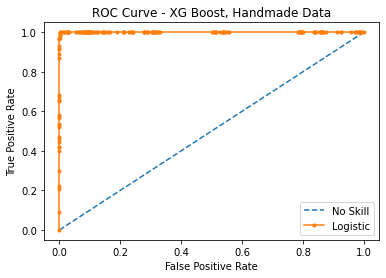

No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


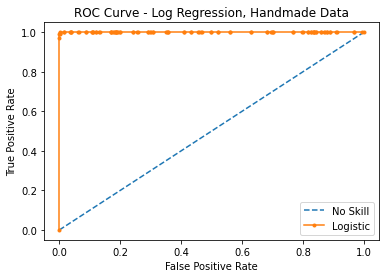

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.994


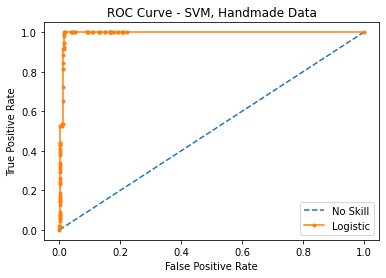


FAA Dataset

Fold 1
XGB Accuracy: 0.9156171284634761
LogReg Accuracy: 0.8677581863979849
SVM Accuracy: 0.8337531486146096

Fold 2
XGB Accuracy: 0.9055415617128464
LogReg Accuracy: 0.8879093198992444
SVM Accuracy: 0.8337531486146096

Fold 3
XGB Accuracy: 0.9118387909319899
LogReg Accuracy: 0.8652392947103275
SVM Accuracy: 0.8337531486146096

Fold 4
XGB Accuracy: 0.9055415617128464
LogReg Accuracy: 0.8614609571788413
SVM Accuracy: 0.8337531486146096

Fold 5
XGB Accuracy: 0.9030226700251889
LogReg Accuracy: 0.8652392947103275
SVM Accuracy: 0.8337531486146096

Receiver Operating Curves (ROC)
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.940


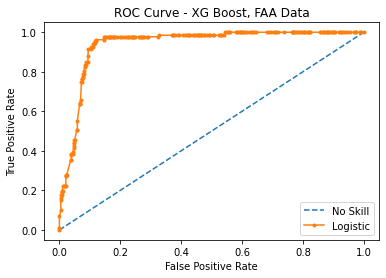

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.907


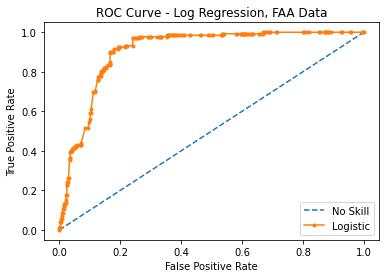

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.380


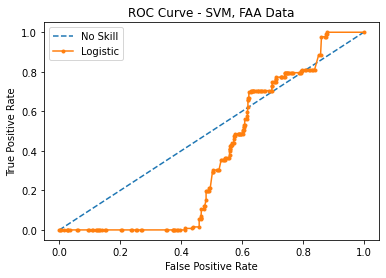

In [15]:
xgb_new = []
xgb_og = []
lr_new = []
lr_og = []
svm_new = []
svm_og = []

print('Handmade Dataset')
count = 1
# Cross Validation XGBoost
for train_index, test_index in sss.split(X.toarray(), y.toarray()): 
    print('\nFold', count)
    count += 1
    X_train, X_test = X.tocsr()[train_index], X.tocsr()[test_index]
    y_train, y_test = y.tocsr()[train_index].toarray(), y.tocsr()[test_index].toarray()
   
    xgb_model = XGBClassifier()
    xgb_model.fit(X_train, y_train)
    xgb_yhat = xgb_model.predict(X_test)

    xgb_new.append(accuracy_score(y_test, xgb_yhat))
    
    print('XGB Accuracy:', accuracy_score(y_test, xgb_yhat))
    
    X_train.data[np.isnan(X_train.data)] = 0
    X_test.data[np.isnan(X_test.data)] = 0
   
    lg_model = LogisticRegression(random_state=0, max_iter=1000, penalty='none')
    lg_model.fit(X_train, np.ravel(y_train))
    lg_yhat = lg_model.predict(X_test)
    
    lr_new.append(accuracy_score(np.ravel(y_test), lg_yhat))
    
    print('LogReg Accuracy:', accuracy_score(np.ravel(y_test), lg_yhat))
    
    svm_model = svm.SVC(random_state=0, C=0.3, probability=True)
    svm_model.fit(X_train, np.ravel(y_train))
    svm_yhat = svm_model.predict(X_test)

    svm_new.append(accuracy_score(y_test, svm_yhat))
    
    print('SVM Accuracy:', accuracy_score(y_test, svm_yhat))
    if count == 6:
        print('\nReceiver Operating Curves (ROC)')
        plotROC(xgb_model, X_test, y_test, 'XG Boost', 'Handmade Data')
        plotROC(lg_model, X_test, y_test, 'Log Regression', 'Handmade Data')
        plotROC(svm_model, X_test, y_test, 'SVM', 'Handmade Data')

print('\nFAA Dataset')
count = 1
# Cross Validation XGBoost
for train_index, test_index in sss_og.split(X_og.toarray(), y_og.toarray()):
    print('\nFold', count)
    count += 1
    X_train, X_test = X_og.tocsr()[train_index], X_og.tocsr()[test_index]
    y_train, y_test = y_og.tocsr()[train_index].toarray(), y_og.tocsr()[test_index].toarray()
   
    xgb_og_model = XGBClassifier()
    xgb_og_model.fit(X_train, y_train)
    xgb_yhat = xgb_og_model.predict(X_test)

    xgb_og.append(accuracy_score(y_test, xgb_yhat))
    
    print('XGB Accuracy:', accuracy_score(y_test, xgb_yhat))
    
    X_train.data[np.isnan(X_train.data)] = 0
    X_test.data[np.isnan(X_test.data)] = 0
   
    lg_og_model = LogisticRegression(random_state=0, max_iter=1000, penalty='none')
    lg_og_model.fit(X_train, np.ravel(y_train))
    lg_yhat = lg_og_model.predict(X_test)
    
    lr_og.append(accuracy_score(np.ravel(y_test), lg_yhat))
    
    print('LogReg Accuracy:', accuracy_score(np.ravel(y_test), lg_yhat))
    
    svm_og_model = svm.SVC(random_state=0, C=0.3, probability=True)
    svm_og_model.fit(X_train, np.ravel(y_train))
    svm_yhat = svm_og_model.predict(X_test)

    svm_og.append(accuracy_score(y_test, svm_yhat))
    
    print('SVM Accuracy:', accuracy_score(y_test, svm_yhat))
    if count == 6:
        print('\nReceiver Operating Curves (ROC)')
        plotROC(xgb_og_model, X_test, y_test, 'XG Boost', 'FAA Data')
        plotROC(lg_og_model, X_test, y_test, 'Log Regression', 'FAA Data')
        plotROC(svm_og_model, X_test, y_test, 'SVM', 'FAA Data')

### Cross Val Barcharts

In [16]:
data = {'XGB':xgb_new,
       'LR':lr_new,
        'SVM':svm_new,
        'XGB*':xgb_og,
        'LR*':lr_og,
        'SVM*':svm_og}

# Creating the Datafame from dict:
df = pd.DataFrame(data).T
df = df.reset_index()
df.columns = ['Model', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5']

In [17]:
data = {'Model':np.repeat(df['Model'].values, 5).tolist(),
       'Fold':np.tile(range(1,6), 6).tolist(),
       'Accuracy':df.loc[:, df.columns!='Model'].values.reshape(1, -1)[0].tolist()}

df2 = pd.DataFrame(data)

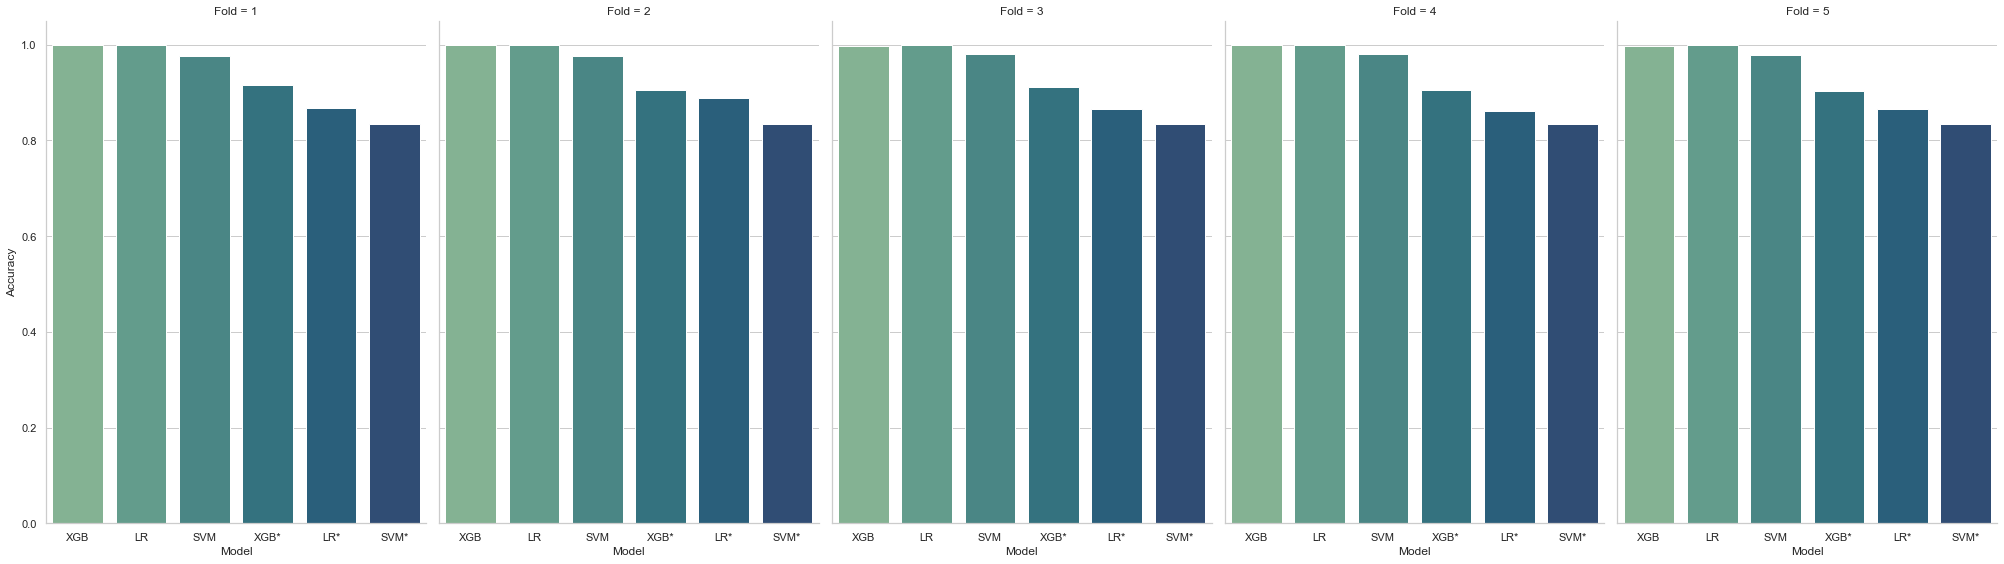

In [18]:
sns.set_theme(style="whitegrid", palette="crest")

p = sns.catplot(x= 'Model', y='Accuracy', col="Fold", data=df2, kind="bar", height=8, aspect=0.7);

## Create Classification Facets

In [19]:
# Combine Features (All Data)
pred = hstack((all_notams['NOTAM_TYPE_ENCODE'].array[:,None], 
                   all_encodes,
                   all_notams['CLASSIFICATION_ENCODE'].array[:,None],
                   all_notams['MIN_ALT'].array[:,None],
                   all_notams['MAX_ALT'].array[:,None],
                   all_notams['LOCATION_CODE_ENCODE'].array[:,None])).A

In [20]:
# Final Model Training
model1a = XGBClassifier()
model1a.fit(X, y.toarray())

# Predict All NOTAMs
all_notams['XGB_NEW'] = model1a.predict(pred)

In [21]:
# Final Model Training
model1b = XGBClassifier()
model1b.fit(X_og, y_og.toarray())

# Predict All NOTAMs
all_notams['XGB'] = model1b.predict(pred)

In [22]:
# Set NAN to 0 for models that cannot deal with NULL
pred[np.isnan(pred)] = 0
X.data[np.isnan(X.data)] = 0
X_og.data[np.isnan(X_og.data)] = 0

In [23]:
# Final Model Training
model2a = LogisticRegression(random_state=0, max_iter=1000, penalty='none')
model2a.fit(X, np.ravel(y.toarray()))

# Predict All NOTAMs
all_notams['LogReg_NEW'] = model2a.predict(pred)

In [24]:
# Final Model Training
model2b = LogisticRegression(random_state=0, max_iter=1000, penalty='none')
model2b.fit(X_og, np.ravel(y_og.toarray()))

# Predict All NOTAMs
all_notams['LogReg'] = model2b.predict(pred)

In [25]:
# Final Model Training
model3a = svm.SVC(random_state=0, C=0.3)
model3a.fit(X, np.ravel(y.toarray()))

# Predict All NOTAMs
all_notams['SVM_NEW'] = model3a.predict(pred)

In [26]:
# Final Model Training
model3b = svm.SVC(random_state=0, C=0.3)
model3b.fit(X_og, np.ravel(y_og.toarray()))

# Predict All NOTAMs
all_notams['SVM'] = model3b.predict(pred)

## Save Pickle File

In [27]:
# Save Results
all_notams.to_pickle("data/allData.pkl")